In [357]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [358]:
# keep the seed
# torch.manual_seed(42)
# np.random.seed(42)

In [359]:
data = pd.read_csv("preprocessed_stock_data.csv", index_col='Date')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change,log_change,7ma,...,7lower,14upper,14lower,21upper,21lower,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components
Date,,,,,,,,,,,,,,,,,,,,,
21,0.082708,0.088389,0.090281,0.100726,0.216567,0.0,0.0,0.563270,0.597003,0.072966,...,0.097430,0.063743,0.088407,0.025319,0.059999,0.444757,0.294416,0.269351,-0.013457,0.076352
22,0.099554,0.092241,0.102644,0.102230,0.215416,0.0,0.0,0.516890,0.551425,0.076935,...,0.096938,0.068056,0.091871,0.030443,0.061259,0.442785,0.289007,0.260026,-0.012724,0.071078
23,0.097108,0.091149,0.100483,0.096602,0.178857,0.0,0.0,0.481001,0.515754,0.078405,...,0.098073,0.070584,0.095135,0.033822,0.063332,0.440827,0.283683,0.250833,-0.009783,0.070011
24,0.101594,0.093724,0.104095,0.100034,0.155658,0.0,0.0,0.526706,0.561119,0.080424,...,0.104670,0.072553,0.099960,0.037103,0.065965,0.438884,0.278445,0.241780,-0.004796,0.072997
25,0.099883,0.089616,0.097999,0.093272,0.134305,0.0,0.0,0.475194,0.509949,0.080132,...,0.114256,0.072587,0.105362,0.038114,0.070722,0.436956,0.273295,0.232874,0.002059,0.079181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,0.907181,0.940341,0.929849,0.952827,0.081873,0.0,0.0,0.624657,0.656453,0.958850,...,0.923220,0.965798,0.999573,0.986971,0.938939,0.500193,0.457212,0.531746,0.676563,0.909538
1254,0.945641,0.937623,0.955008,0.936801,0.035529,0.0,0.0,0.472335,0.507088,0.964073,...,0.923738,0.960801,0.999947,0.985313,0.952817,0.497945,0.450427,0.521825,0.642622,0.844106
1255,0.936934,0.941852,0.951458,0.953054,0.024739,0.0,0.0,0.547191,0.581267,0.972328,...,0.920186,0.960440,1.000000,0.985581,0.964833,0.495704,0.443664,0.511828,0.607372,0.761317


In [ ]:
data['y'] = data['Close']
feature_columns = [col for col in data.columns if col != 'Close' and col != 'y']
# print(feature_columns)
x = data[feature_columns].values
y = data['y'].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'pct_change', 'log_change', '7ma', '14ma', '21ma', '7macd', '14macd', '7rsi', '14rsi', '21rsi', '7atr', '14atr', '21atr', '7upper', '7lower', '14upper', '14lower', '21upper', '21lower', 'FT_3components', 'FT_6components', 'FT_9components', 'FT_27components', 'FT_81components']
trainX: (989, 30) trainY: (989,)
testX: (248, 30) testY: (248,)


In [361]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [362]:
# train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# model = VAE(input_dim=num_cols, hidden_dims=[400, 400, 400,10], latent_dim=10)

model = VAE(input_dim=30,  # Changed to optimal input dimension
           hidden_dims=[484, 832, 1022, 138],  # New optimized dimensions
           latent_dim=36)  # 

train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), 
                         batch_size=32,  # Changed to optimal batch size
                         shuffle=False)

[1/300] Loss: 93.95669198036194
[2/300] Loss: 79.42670750617981
[3/300] Loss: 68.30213665962219
[4/300] Loss: 59.59703493118286
[5/300] Loss: 54.22933280467987
[6/300] Loss: 50.23032879829407
[7/300] Loss: 45.20805048942566
[8/300] Loss: 40.1185736656189
[9/300] Loss: 35.73523211479187
[10/300] Loss: 32.14721459150314
[11/300] Loss: 29.508654534816742
[12/300] Loss: 27.75144213438034
[13/300] Loss: 26.592769384384155
[14/300] Loss: 25.584562063217163
[15/300] Loss: 24.460858166217804
[16/300] Loss: 23.4824640750885
[17/300] Loss: 23.027410566806793
[18/300] Loss: 22.791215300559998
[19/300] Loss: 22.583842396736145
[20/300] Loss: 22.327669143676758
[21/300] Loss: 22.16860145330429
[22/300] Loss: 22.097725093364716
[23/300] Loss: 22.009369254112244
[24/300] Loss: 21.948253512382507
[25/300] Loss: 21.961450040340424
[26/300] Loss: 21.93801212310791
[27/300] Loss: 21.85489571094513
[28/300] Loss: 21.79220873117447
[29/300] Loss: 21.801736295223236
[30/300] Loss: 21.840712189674377
[31/300

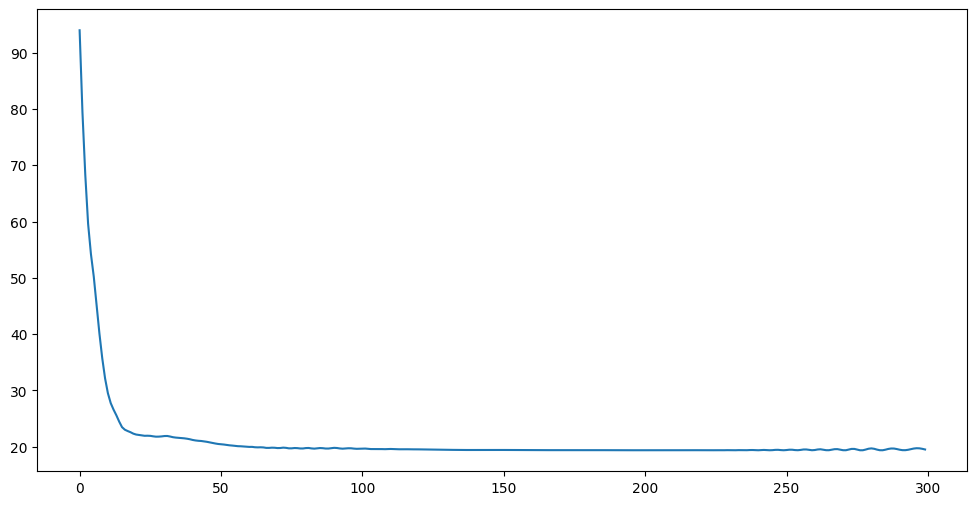

In [363]:
num_epochs = 300
learning_rate = 6.536830781589905e-06
# model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [364]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float())
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float())

In [365]:
# our existing time series window function
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [366]:
train_x = np.concatenate((train_x, VAE_train_x.detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.detach().numpy()), axis = 1)

In [367]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([986, 3, 66]) train_y: torch.Size([986, 1]) train_y_gan: torch.Size([986, 4, 1])
test_x: torch.Size([245, 3, 66]) test_y: torch.Size([245, 1]) test_y_gan: torch.Size([245, 4, 1])


In [368]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 652, batch_first=True)  # Changed to 652
        self.gru_2 = nn.GRU(652, 893, batch_first=True)        # Changed to 893
        self.gru_3 = nn.GRU(893, 482, batch_first=True)        # Changed to 482
        self.linear_1 = nn.Linear(482, 164)                    # Changed to 164
        self.linear_2 = nn.Linear(164, 115)                    # Changed to 115
        self.linear_3 = nn.Linear(115, 1)
        self.dropout = nn.Dropout(0.153848576505225)           # New dropout rate

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 652)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)

        h1 = torch.zeros(1, x.size(0), 893)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)

        h2 = torch.zeros(1, x.size(0), 482)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 50, kernel_size=3, stride=1, padding='same')  # 50 filters
        self.conv2 = nn.Conv1d(50, 60, kernel_size=3, stride=1, padding='same') # 60 filters
        self.conv3 = nn.Conv1d(60, 211, kernel_size=3, stride=1, padding='same') # 211 filters
        self.linear1 = nn.Linear(211, 155)  # Changed to 155
        self.linear2 = nn.Linear(155, 155)  # Keep same dimension
        self.linear3 = nn.Linear(155, 1)
        self.leaky = nn.LeakyReLU(0.0666677684638632)  # Optimized slope
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2741225785366103)  # Optimized dropout

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        return torch.sigmoid(out_3)

[1/165] LossD: 42.96033728122711 LossG:21.36286425590515
[2/165] LossD: 42.97757053375244 LossG:21.474342584609985
[3/165] LossD: 42.97344613075256 LossG:21.49016910791397
[4/165] LossD: 42.97306668758392 LossG:21.49008584022522
[5/165] LossD: 42.97369933128357 LossG:21.49134075641632
[6/165] LossD: 42.97477102279663 LossG:21.489237368106842
[7/165] LossD: 42.975038051605225 LossG:21.488268554210663
[8/165] LossD: 42.97493600845337 LossG:21.487851321697235
[9/165] LossD: 42.97471570968628 LossG:21.488608181476593
[10/165] LossD: 42.974870681762695 LossG:21.488521337509155
[11/165] LossD: 42.97464215755463 LossG:21.487983286380768
[12/165] LossD: 42.97480666637421 LossG:21.488102853298187
[13/165] LossD: 42.97461926937103 LossG:21.48777163028717
[14/165] LossD: 42.97477388381958 LossG:21.487902104854584
[15/165] LossD: 42.97469234466553 LossG:21.48819398880005
[16/165] LossD: 42.97456681728363 LossG:21.488541662693024
[17/165] LossD: 42.97459554672241 LossG:21.488345742225647
[18/165] L

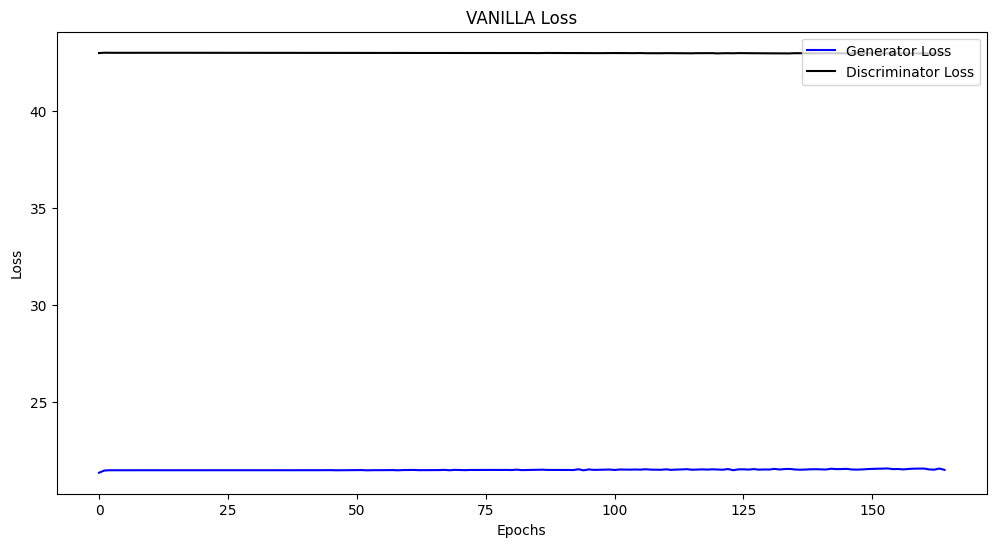

In [369]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1))
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Calculate critic scores
    d_interpolates = D(interpolates)
    
    # Get gradients w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    # Get gradient penalty
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_gan(gan_type='vanilla', lambda_gp=10, weight_clip=0.01):
    """
    Unified training function for different GAN variants
    Args:
        gan_type: 'vanilla', 'wgan', or 'wgan_gp'
        lambda_gp: Gradient penalty coefficient for WGAN-GP
        weight_clip: Weight clipping value for WGAN
    """
    # Hyperparameters
    batch_size = 32
    learning_rate_G = 3.319668704256778e-05
    learning_rate_D = 9.506230598366327e-05
    num_epochs = 165

    # DataLoader
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), 
                               batch_size=batch_size, 
                               shuffle=False)

    # Initialize models
    modelG = Generator(66)
    modelD = Discriminator()

    # Optimizers
    optimizerG = torch.optim.Adam(modelG.parameters(), 
                                 lr=learning_rate_G, 
                                 betas=(0.0, 0.9))
    optimizerD = torch.optim.Adam(modelD.parameters(), 
                                 lr=learning_rate_D, 
                                 betas=(0.0, 0.9))

    # Loss function for vanilla GAN
    criterion = nn.BCELoss() if gan_type == 'vanilla' else None

    # Initialize history tracking
    histG = np.zeros(num_epochs)
    histD = np.zeros(num_epochs)

    # Training loop
    for epoch in range(num_epochs):
        loss_G = []
        loss_D = []
        for (x, y) in trainDataloader:

            # Generate fake data
            fake_data = modelG(x)
            fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

            # Train Discriminator
            if gan_type == 'vanilla':
                dis_real_output = modelD(y)
                dis_fake_output = modelD(fake_data.detach())
                
                real_labels = torch.ones_like(dis_real_output)
                fake_labels = torch.zeros_like(dis_real_output)
                
                lossD_real = criterion(dis_real_output, real_labels)
                lossD_fake = criterion(dis_fake_output, fake_labels)
                lossD = lossD_real + lossD_fake

            else:  # WGAN variants
                dis_real_output = modelD(y)
                dis_fake_output = modelD(fake_data.detach())
                
                if gan_type == 'wgan_gp':
                    gradient_penalty = compute_gradient_penalty(modelD, y, fake_data.detach())
                    lossD = -torch.mean(dis_real_output) + torch.mean(dis_fake_output) + lambda_gp * gradient_penalty
                else:  # wgan
                    lossD = -(torch.mean(dis_real_output) - torch.mean(dis_fake_output))

            modelD.zero_grad()
            lossD.backward(retain_graph=True)
            optimizerD.step()

            # Weight clipping for WGAN
            if gan_type == 'wgan':
                for p in modelD.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)

            loss_D.append(lossD.item())

            # Train Generator
            if gan_type == 'vanilla':
                output_fake = modelD(fake_data)
                lossG = criterion(output_fake, real_labels)
            else:  # WGAN variants
                output_fake = modelD(fake_data)
                lossG = -torch.mean(output_fake)

            modelG.zero_grad()
            lossG.backward()
            optimizerG.step()
            loss_G.append(lossG.item())

        histG[epoch] = sum(loss_G)
        histD[epoch] = sum(loss_D)    
        print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

    # Plotting training progress
    plt.figure(figsize=(12, 6))
    plt.plot(histG, color='blue', label='Generator Loss')
    plt.plot(histD, color='black', label='Discriminator Loss')
    plt.title(f'{gan_type.upper()} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

    return modelG, modelD, histG, histD

# Usage example:
# For vanilla GAN:
modelG, modelD, histG, histD = train_gan(gan_type='vanilla')

# For WGAN with weight clipping:
# modelG, modelD, histG, histD = train_gan(gan_type='wgan', weight_clip=0.01)

# For WGAN-GP:
# modelG, modelD, histG, histD = train_gan(gan_type='wgan_gp', lambda_gp=10)

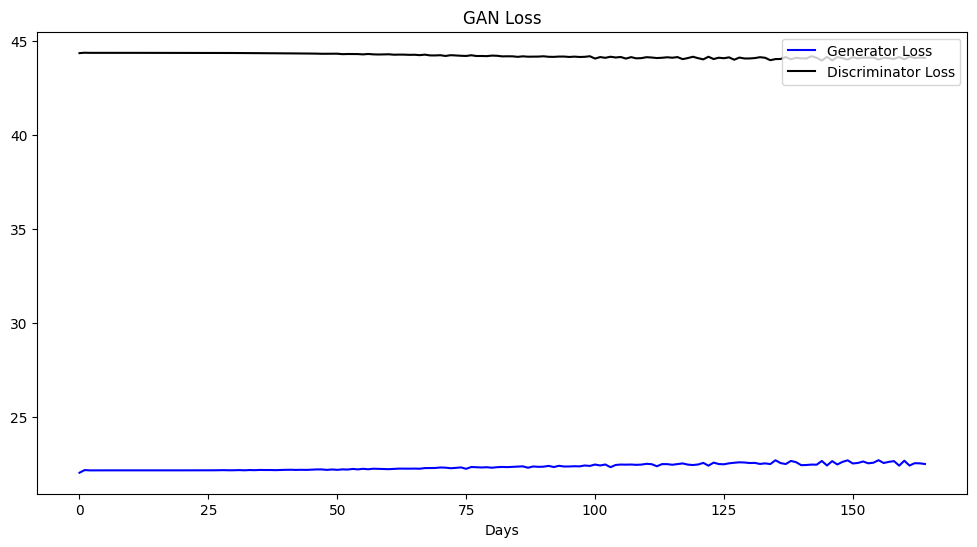

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide)
pred_y_test = modelG(test_x_slide)

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:0.018377736892221445


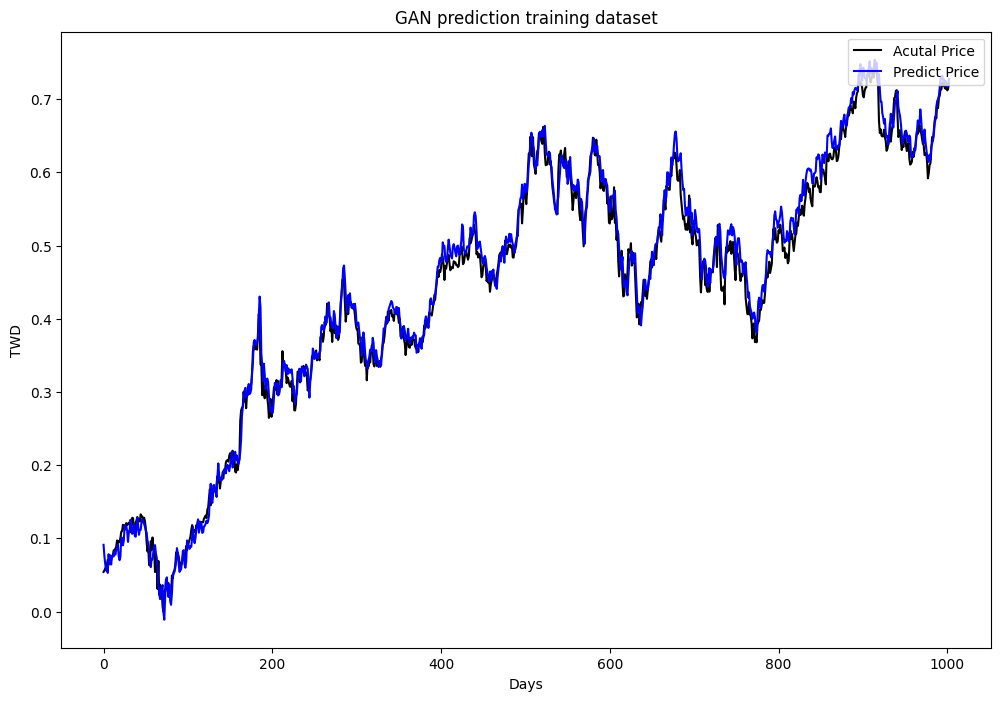

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:0.03336245906362252


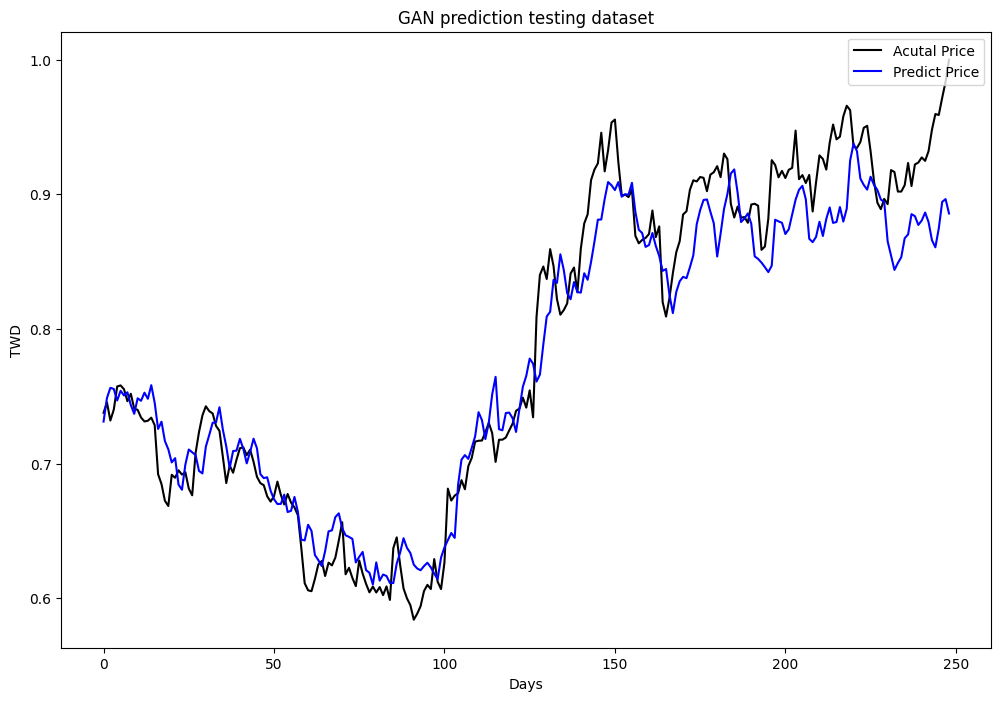

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')